In [1]:
import pandas as pd
import numpy as np
import copy
import pickle

from surprise import KNNBaseline, KNNWithMeans, NMF
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise import KNNBasic, SVD
from surprise import get_dataset_dir
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

from scipy import spatial

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")

In [2]:
reviews= pd.read_csv('~/den-19/capstone3/data/reviews.csv')
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9073128 entries, 0 to 9073127
Data columns (total 10 columns):
 #   Column    Dtype  
---  ------    -----  
 0   beer_id   int64  
 1   username  object 
 2   date      object 
 3   text      object 
 4   look      float64
 5   smell     float64
 6   taste     float64
 7   feel      float64
 8   overall   float64
 9   score     float64
dtypes: float64(6), int64(1), object(3)
memory usage: 692.2+ MB


In [3]:
reviews_1= reviews[['beer_id', 'username','look','smell','taste','feel','overall','score']].sort_values(['beer_id'], ascending=True)
reviews_1 = reviews_1.reset_index()
reviews_1 = reviews_1.fillna(0)
reviews_1 = reviews_1.drop(['index'], axis = 1)
reviews_1.head()

,beer_id,username,look,smell,taste,feel,overall,score
0,3,Jason,3.5,4.0,4.0,4.5,4.0,4.02
1,3,Morris729,4.0,3.5,4.0,4.0,4.0,3.88
2,3,MAB,4.0,4.5,4.5,4.0,4.5,4.42
3,4,allengarvin,3.5,3.5,3.5,4.0,3.5,3.55
4,4,bditty187,4.0,3.0,3.0,3.5,3.5,3.21


In [4]:
reviews_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9073128 entries, 0 to 9073127
Data columns (total 8 columns):
 #   Column    Dtype  
---  ------    -----  
 0   beer_id   int64  
 1   username  object 
 2   look      float64
 3   smell     float64
 4   taste     float64
 5   feel      float64
 6   overall   float64
 7   score     float64
dtypes: float64(6), int64(1), object(1)
memory usage: 553.8+ MB


In [5]:
beers = pd.read_csv('~/den-19/capstone3/data/beers.csv')
beers.columns

Index(['id', 'name', 'brewery_id', 'state', 'country', 'style', 'availability',
       'abv', 'notes', 'retired'],
      dtype='object')

In [6]:
beers_1= beers[['id', 'name', 'brewery_id', 'style']]
beers_1 = beers_1.rename(columns= {'id':'beer_id', 'name':'beer_name'})
beers_1 = beers_1.sort_values(['beer_id'], ascending= True)
#beers_1.set_index('beer_id')
beers_1.head()

,beer_id,beer_name,brewery_id,style
8752,3,Cactus Queen IPA,2,American IPA
8760,4,Wildcatter's Crude Stout,2,American Stout
8817,5,Amber,3,Vienna Lager
8818,6,Turbodog,3,English Brown Ale
8819,7,Purple Haze,3,Fruit and Field Beer


In [7]:
brewery = pd.read_csv('~/den-19/capstone3/data/breweries.csv')
brewery.columns

Index(['id', 'name', 'city', 'state', 'country', 'notes', 'types'], dtype='object')

In [8]:
brewery_1 = brewery[['id', 'name']]
brewery_1 = brewery_1.rename(columns={'id':'brewery_id', 'name':'brewery_name'})
brewery_1 = brewery_1.sort_values(['brewery_id'])

brewery_1.head(10)

#I can clean this up a little by moving the rename "name" up 

,brewery_id,brewery_name
17575,1,Plzeňský Prazdroj
16112,2,Yellow Rose Brewing Company
23348,3,Abita Brewing Co.
38987,4,Allagash Brewing Company
49940,5,Yakima Brewing Co. / Bert Grant's Ales
18806,6,Brouwerij Slaghmuylder
38157,8,Widmer Brothers Brewing Company
40270,9,Whitbread PLC
18176,10,Whim Ales
7427,11,North East Brewing Company


In [9]:
both = pd.merge(brewery_1, beers_1[['brewery_id', 'style', 'beer_name', 'beer_id']], on = 'brewery_id')

both.head()

,brewery_id,brewery_name,style,beer_name,beer_id
0,1,Plzeňský Prazdroj,Bohemian Pilsener,Pilsner Urquell,429
1,1,Plzeňský Prazdroj,Bohemian Pilsener,Gambrinus,5916
2,1,Plzeňský Prazdroj,Bohemian Pilsener,Eisbrau Czech,14348
3,1,Plzeňský Prazdroj,Bohemian Pilsener,Primus,19099
4,1,Plzeňský Prazdroj,Bohemian Pilsener,Gambrinus Pale,19123


In [10]:
all_three = pd.merge(reviews_1, both[['beer_name','brewery_name','style', 'beer_id']], on = 'beer_id')
all_three.head()

,beer_id,username,look,smell,taste,feel,overall,score,beer_name,brewery_name,style
0,3,Jason,3.5,4.0,4.0,4.5,4.0,4.02,Cactus Queen IPA,Yellow Rose Brewing Company,American IPA
1,3,Morris729,4.0,3.5,4.0,4.0,4.0,3.88,Cactus Queen IPA,Yellow Rose Brewing Company,American IPA
2,3,MAB,4.0,4.5,4.5,4.0,4.5,4.42,Cactus Queen IPA,Yellow Rose Brewing Company,American IPA
3,4,allengarvin,3.5,3.5,3.5,4.0,3.5,3.55,Wildcatter's Crude Stout,Yellow Rose Brewing Company,American Stout
4,4,bditty187,4.0,3.0,3.0,3.5,3.5,3.21,Wildcatter's Crude Stout,Yellow Rose Brewing Company,American Stout


In [11]:
all_three_1 = all_three[['username', 'score', 'beer_name', 'brewery_name','style']]
all_three_1.head(10)

,username,score,beer_name,brewery_name,style
0,Jason,4.02,Cactus Queen IPA,Yellow Rose Brewing Company,American IPA
1,Morris729,3.88,Cactus Queen IPA,Yellow Rose Brewing Company,American IPA
2,MAB,4.42,Cactus Queen IPA,Yellow Rose Brewing Company,American IPA
3,allengarvin,3.55,Wildcatter's Crude Stout,Yellow Rose Brewing Company,American Stout
4,bditty187,3.21,Wildcatter's Crude Stout,Yellow Rose Brewing Company,American Stout
5,NeroFiddled,4.10,Wildcatter's Crude Stout,Yellow Rose Brewing Company,American Stout
6,assurbanipaul,3.45,Wildcatter's Crude Stout,Yellow Rose Brewing Company,American Stout
7,AtrumAnimus,4.88,Wildcatter's Crude Stout,Yellow Rose Brewing Company,American Stout
8,GreenCard,2.67,Wildcatter's Crude Stout,Yellow Rose Brewing Company,American Stout
9,Morris729,3.68,Wildcatter's Crude Stout,Yellow Rose Brewing Company,American Stout


In [12]:
all_three_1.describe()

,score
count,9.072914e+06
mean,3.889811e+00
std,6.127441e-01
min,1.000000e+00
25%,3.570000e+00
50%,4.000000e+00
75%,4.250000e+00
max,5.000000e+00


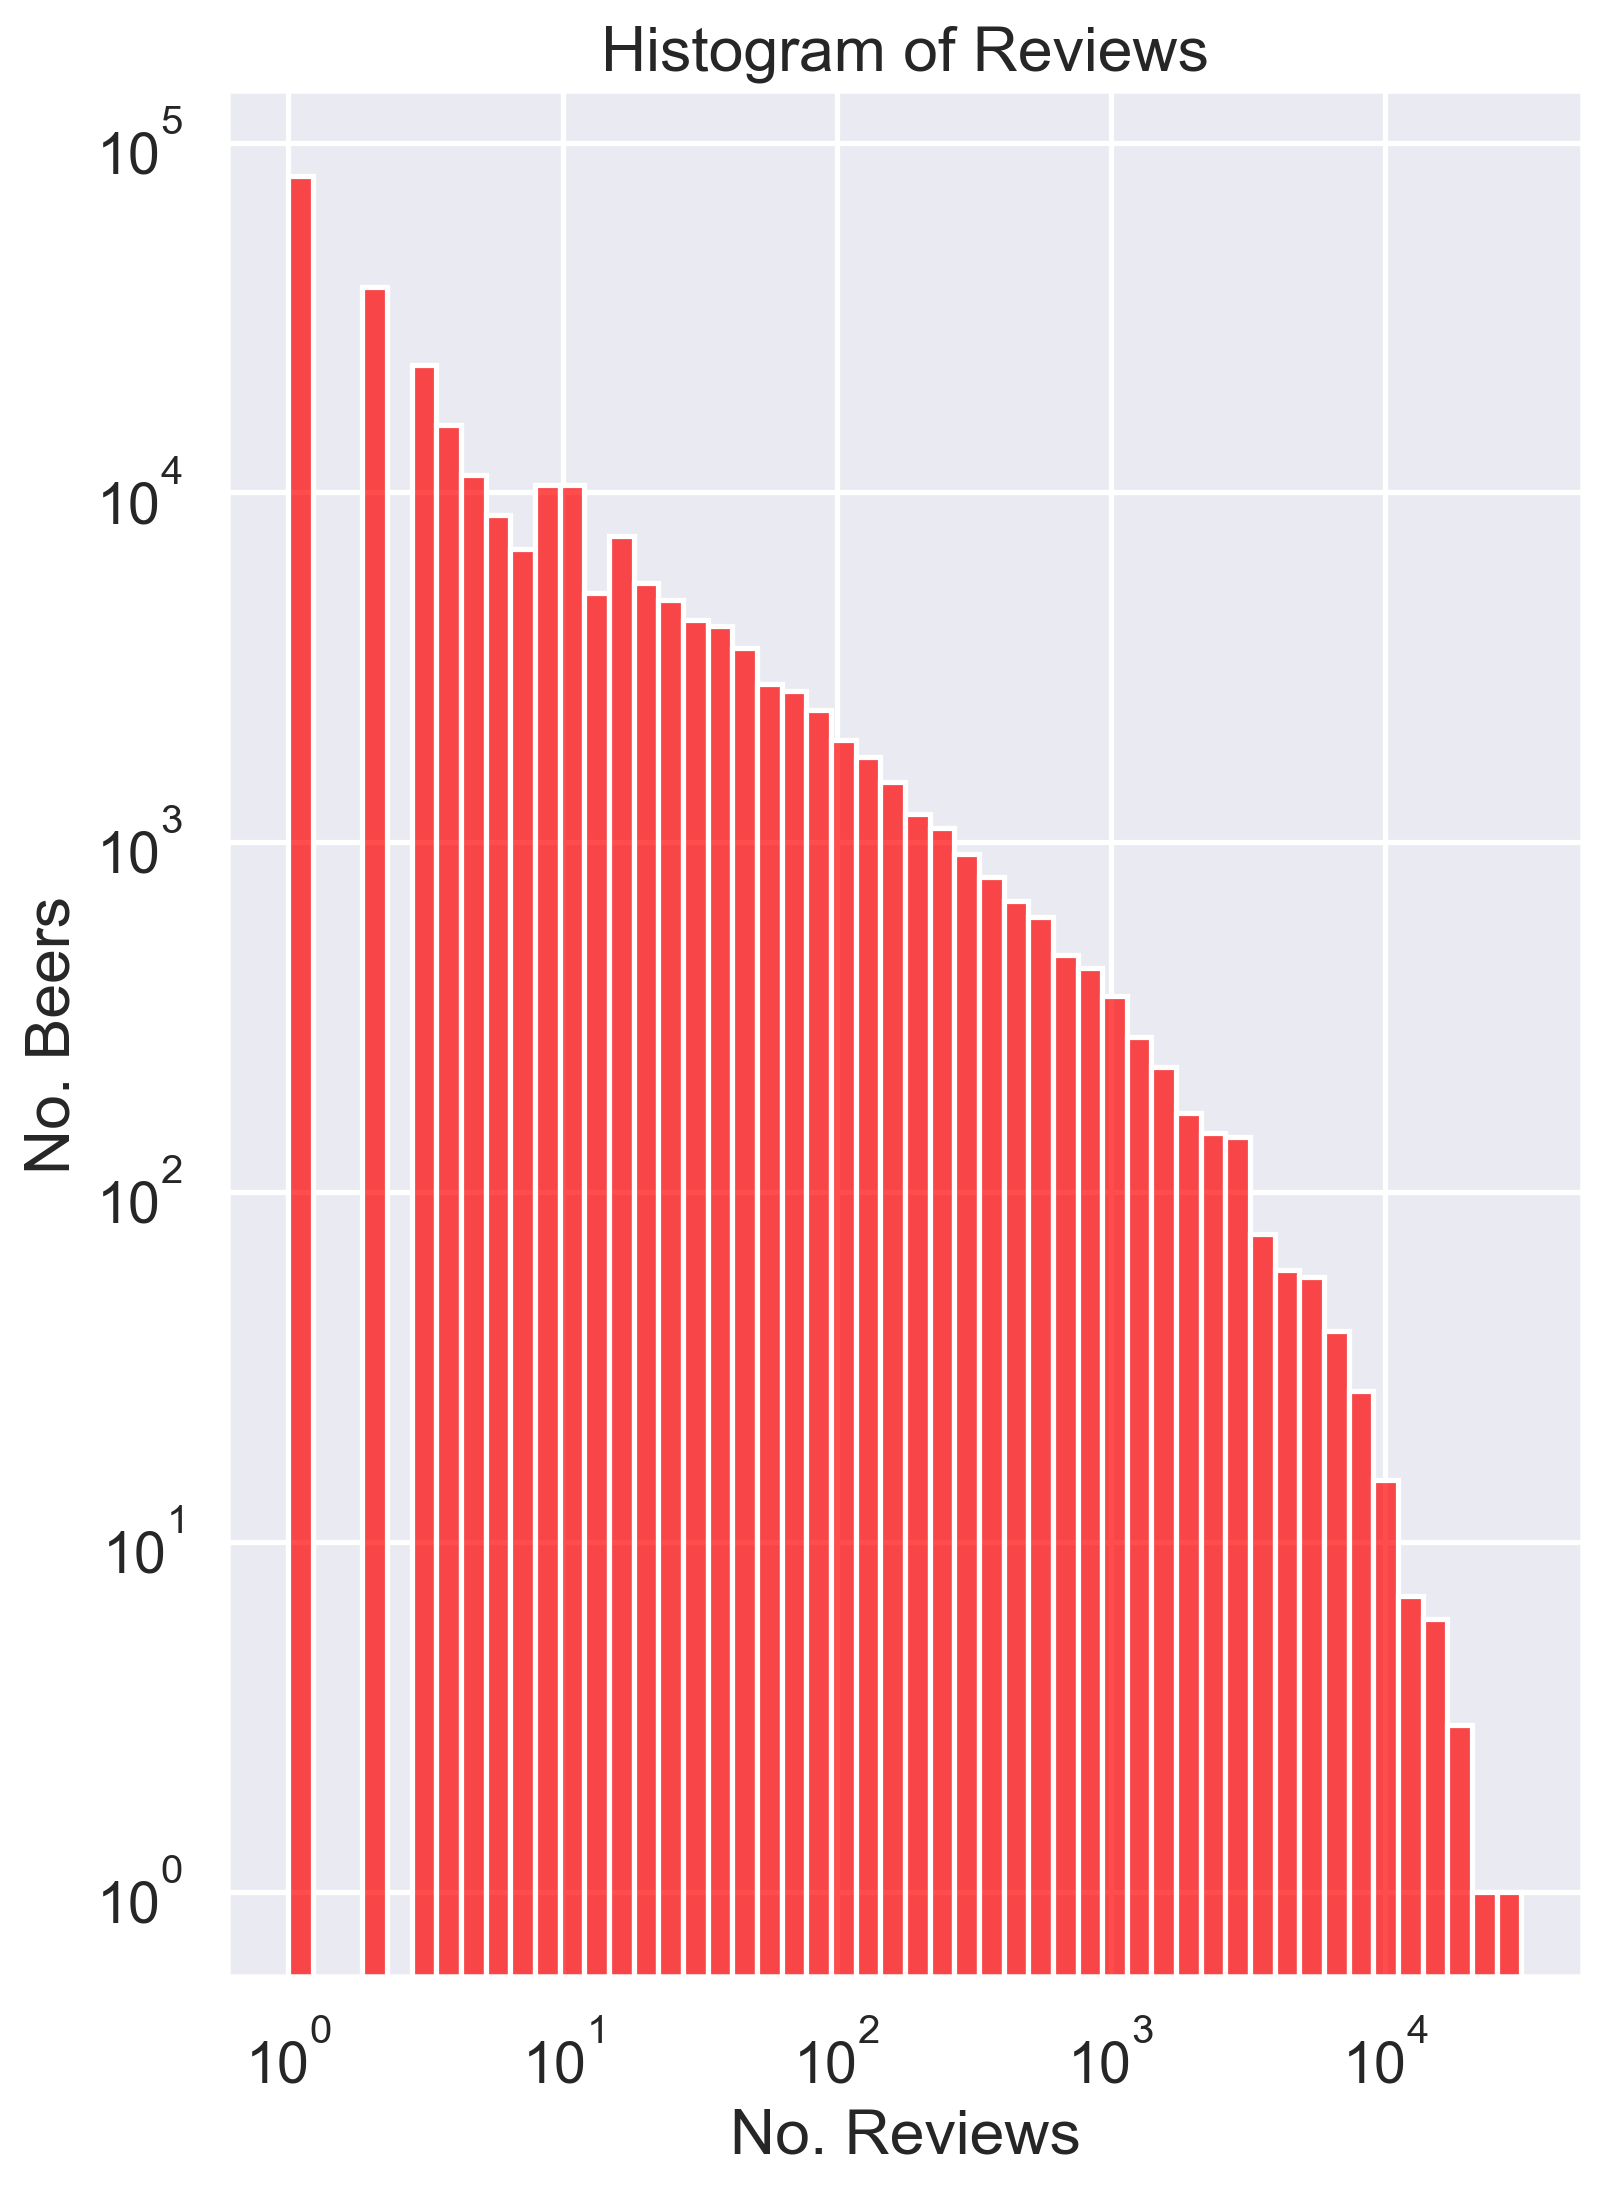

In [64]:
data=all_three_1.beer_name.value_counts()
sns.set_context("talk")
sns.set_style("darkgrid")
#This plots the hist w/out kde
plt.figure(figsize=(7,10), dpi= 250)
ax = sns.histplot(data, bins = 50, kde=False,color='red', alpha = .7, log_scale= (True, True))

#Creates another Y axis
#second_ax = ax.twinx()

#Plotting the kde w/out the hist on the second Y axis
#sns.distplot(data, ax=second_ax, kde=True, hist= False, color='blue')

#Removing Y ticks from 2nd axis
#second_ax.set_yticks([])

#Labels
ax.set_xlabel('No. Reviews')
ax.set_ylabel('No. Beers')
ax.set_title('Histogram of Reviews');


#plt.savefig('Review_Counts_logfin.png')

In [74]:
grouped_styles = all_three_1.groupby('style')

In [81]:
grouped_styles1 = grouped_styles.count().sort_values( by='username', ascending=False)
grouped_styles1.describe()

,username,score,beer_name,brewery_name
count,1.120000e+02,1.120000e+02,1.120000e+02,1.120000e+02
mean,8.100814e+04,8.100814e+04,8.100814e+04,8.100814e+04
std,1.420587e+05,1.420587e+05,1.420587e+05,1.420587e+05
min,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
25%,1.765900e+04,1.765900e+04,1.765900e+04,1.765900e+04
50%,4.304550e+04,4.304550e+04,4.304550e+04,4.304550e+04
75%,8.750500e+04,8.750500e+04,8.750500e+04,8.750500e+04
max,1.072015e+06,1.072015e+06,1.072015e+06,1.072015e+06


In [14]:
grouped_beers = all_three_1.groupby('beer_name')

In [15]:
grouped_beers.count().sort_values(by='username', ascending = False).quantile(np.arange(0,1,.05))

,username,score,brewery_name,style
0.00,1.0,1.0,1.0,0.0
0.05,1.0,1.0,1.0,1.0
0.10,1.0,1.0,1.0,1.0
0.15,1.0,1.0,1.0,1.0
0.20,1.0,1.0,1.0,1.0
0.25,1.0,1.0,1.0,1.0
0.30,1.0,1.0,1.0,1.0
0.35,2.0,2.0,2.0,2.0
0.40,2.0,2.0,2.0,2.0
0.45,2.0,2.0,2.0,2.0


In [16]:
grouped_beers.mean().sort_values(by= 'score', ascending=False).quantile(np.arange(0,1,.05))

,score
0.00,1.000000
0.05,2.940000
0.10,3.223333
0.15,3.375000
0.20,3.490000
0.25,3.546429
0.30,3.615809
0.35,3.675000
0.40,3.730000
0.45,3.760596


In [17]:
avg_score= grouped_beers.mean()
#beers with average rating less than 4.0 are not worth recommending, and 
#i wanted to save on computational power

below_avg = avg_score['score'] < 4.0
below_avg_count = len(avg_score[below_avg])

print('{} beers have an average score below 4.0'.format(below_avg_count))
print('A 4.0 avg score puts the beer within the bottom 70th%-tile')

182227 beers have an average score below 4.0
A 4.0 avg score puts the beer within the bottom 70th%-tile


In [18]:
# bottom_20percent_rating = grouped_beers.mean().quantile(np.arange(0,.21,.02))
# bottom_20percent_counts = grouped_beers.count().quantile(np.arange(0,.21,.02))

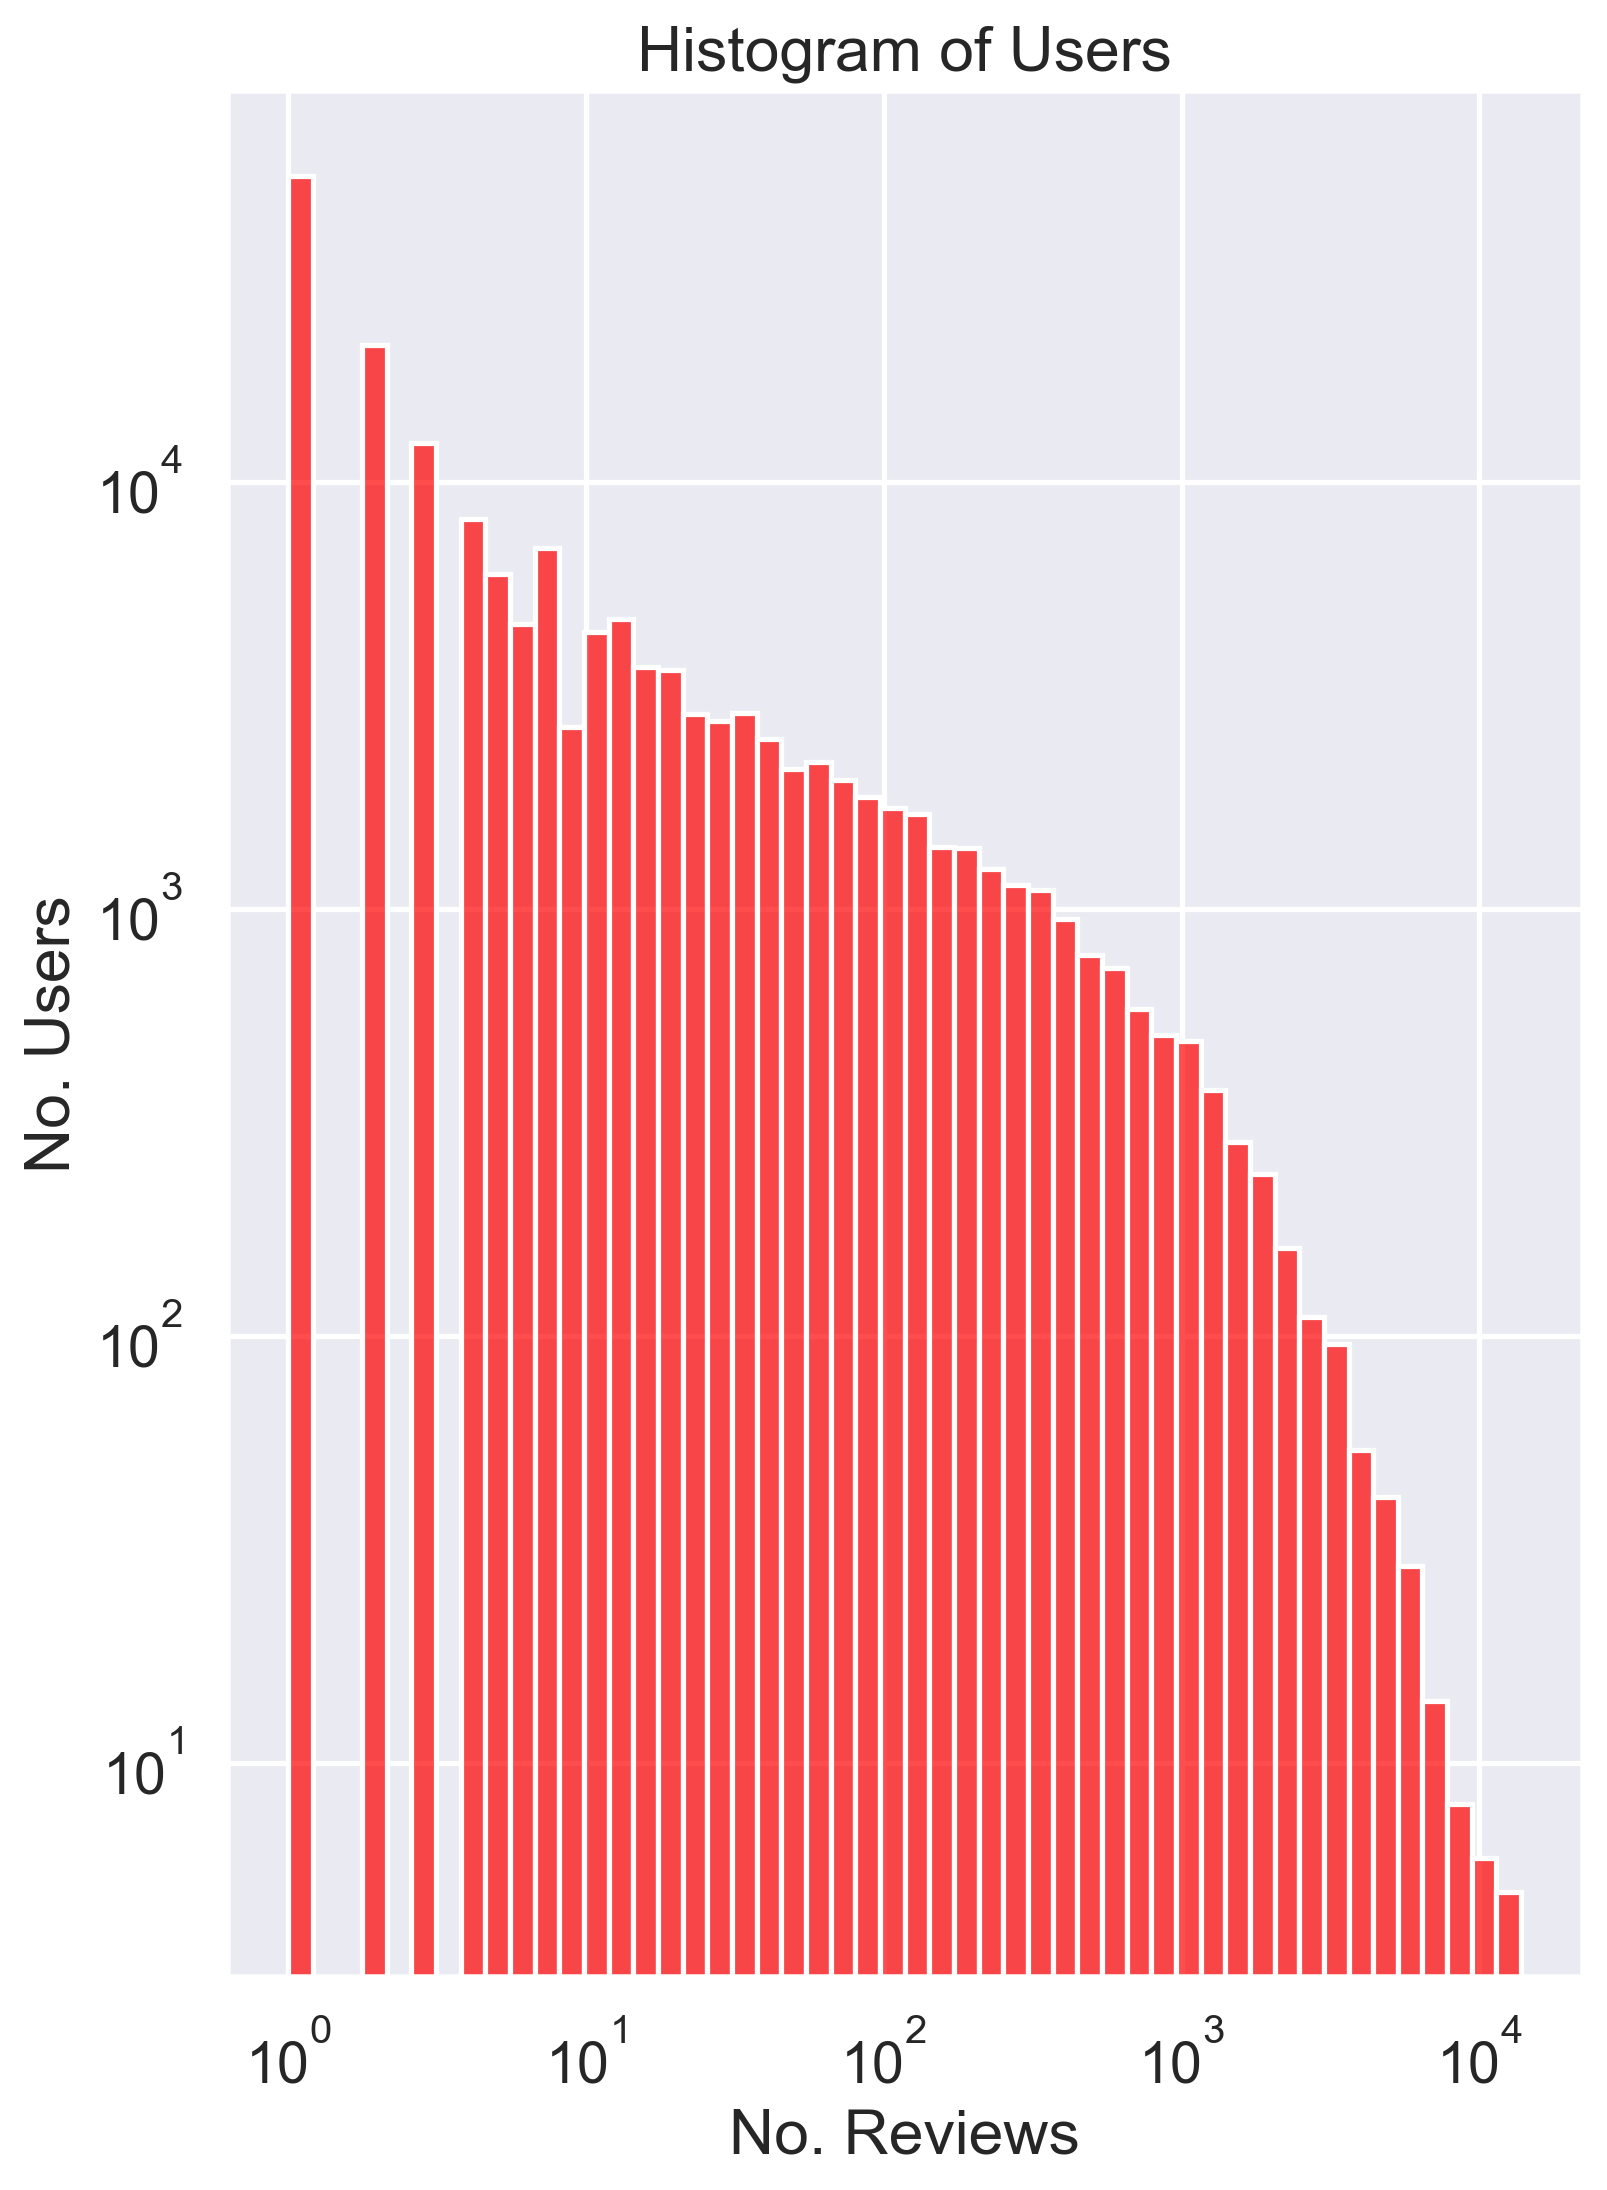

In [63]:
data2=all_three_1.username.value_counts()
sns.set_style('darkgrid')
sns.set_context('talk')
plt.figure(figsize= (7,10), dpi=250)
ax2 = sns.histplot(data2, bins = 50, kde=False, color='red', alpha=.7, log_scale= (True,True))

#second_ax2 = ax2.twinx()

#sns.distplot(data2, ax=second_ax2, kde=True, hist= False, color='blue')

#second_ax2.set_yticks([])

ax2.set_xlabel('No. Reviews')
ax2.set_ylabel('No. Users')
ax2.set_title('Histogram of Users');

#plt.savefig('User_counts_logfin.png')

In [20]:
grouped_users= all_three_1.groupby('username')

In [21]:
grouped_users_count = grouped_users.count()

counts = [1,2,3,4,5,10,15,20]
for ct in counts:
    num_users = grouped_users_count[grouped_users_count['score'] <= ct].count()[0]
    print('{} users rated {} or fewer beers'.format(num_users, ct))

print('\n')
print('Total Unique Users in this dataset: {}'.format(len(all_three_1.username.unique())))

52181 users rated 1 or fewer beers
73066 users rated 2 or fewer beers
85405 users rated 3 or fewer beers
93620 users rated 4 or fewer beers
99708 users rated 5 or fewer beers
116396 users rated 10 or fewer beers
124641 users rated 15 or fewer beers
129740 users rated 20 or fewer beers


Total Unique Users in this dataset: 164933


In [22]:
subpar_beers_list= list(avg_score[below_avg].index)

ratings_count = grouped_beers.count()

#Here i'm setting beers that have ratings counts less than 20 to be called low amount of ratings

low_ratings_count = ratings_count[ratings_count['score'] < 20]
low_ratings_list = list(low_ratings_count.index)

In [23]:
unique_subpar_beers = set(subpar_beers_list)
unique_low_ratings_beers = set(low_ratings_list)
overlap = unique_subpar_beers.intersection(unique_low_ratings_beers)
print('Number of beers in bottom 50% of avg rating: {}'.format(len(unique_subpar_beers)))
print('Number of beers in bottom 50% of review counts: {}'.format(len(unique_low_ratings_beers)))
print('Number of beers in both categories: {}'.format(len(overlap)))

Number of beers in bottom 50% of avg rating: 182227
Number of beers in bottom 50% of review counts: 219894
Number of beers in both categories: 153558


In [24]:
#Here the beers that are in the bottom of both categories are removed
df1 = all_three_1[~all_three_1.beer_name.isin(subpar_beers_list)]
df2 = df1[~df1.beer_name.isin(low_ratings_list)]
all_three_2 = copy.deepcopy(df2)

In [25]:
all_three_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3569155 entries, 13052 to 9072897
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   username      object 
 1   score         float64
 2   beer_name     object 
 3   brewery_name  object 
 4   style         object 
dtypes: float64(1), object(4)
memory usage: 163.4+ MB


In [26]:
print('Original number of unique beers: {}'.format(len(all_three_1.beer_name.unique())))

print('Revised number of unique beers: {}'.format(len(all_three_2.beer_name.unique())))

Original number of unique beers: 261837
Revised number of unique beers: 13274


In [27]:
#creating a new beerID for each beer
grouped_name = all_three_2.groupby('beer_name')
temp_df = grouped_name.count()
temp_df_idx = pd.DataFrame(temp_df.index)

temp_df_idx['beerID'] = temp_df_idx.index
dict_df = temp_df_idx[['beerID', 'beer_name']]

desc_dict = dict_df.set_index('beer_name').to_dict()
new_dict = desc_dict['beerID']

all_three_2['beerID']= all_three_2.beer_name.map(new_dict)

#creating a new userID for each user
grouped_user = all_three_2.groupby('username')

temp_df_user = grouped_user.count()
temp_df_user_idx = pd.DataFrame(temp_df_user.index)

temp_df_user_idx['userID'] = temp_df_user_idx.index
dict_df_user = temp_df_user_idx[['userID', 'username']]

desc_dict_user = dict_df_user.set_index('username').to_dict()
new_dict_user = desc_dict_user['userID']

all_three_2['userID'] = all_three_2.username.map(new_dict_user)


In [28]:
all_three_2.head()

,username,score,beer_name,brewery_name,style,beerID,userID
13052,Michelle68Bressler,4.50,Mackeson Triple XXX Stout,Whitbread PLC,English Sweet / Milk Stout,7478,41312
13053,CalgaryFMC,3.78,Mackeson Triple XXX Stout,Whitbread PLC,English Sweet / Milk Stout,7478,11221
13054,MaddDogg84,5.00,Mackeson Triple XXX Stout,Whitbread PLC,English Sweet / Milk Stout,7478,38856
13055,BillRoth,4.00,Mackeson Triple XXX Stout,Whitbread PLC,English Sweet / Milk Stout,7478,7440
13056,dbaker61,3.75,Mackeson Triple XXX Stout,Whitbread PLC,English Sweet / Milk Stout,7478,77030


In [29]:
def read_item_names():
    file_name = dict_df
    raw_id_to_name = {}
    name_to_raw_id = {}
    
    #there were 13274 unique beers after removing those w/ low rating and review counts
    unique_beers= len(all_three_2.beer_name.unique())
    

    for i in range(unique_beers):
        line=file_name.iloc[i]
        raw_id_to_name[line[0]] = line[1]
        name_to_raw_id[line[1]] = line[0]
        

    return raw_id_to_name, name_to_raw_id
    


In [30]:
# #Train the algorithm to compute the similarities between items (item-item collaborative filtering)

# reader= Reader(rating_scale=(1,5))
# data= Dataset.load_from_df(all_three_2[['userID', 'beerID', 'score']],reader)
# trainset = data.build_full_trainset()
# sim_options = {'username':'pearson_baseline', 'user_based': False}
# algo= KNNBaseline(sim_options = sim_options)
# algo.fit(trainset)

# predictions = algo.test(testset)
# accuracy.rmse(predictions)

In [31]:
def get_recommendation(beer_name, k_):
    '''Input a beer and get k recommendations 
       that are based on similarity
       
       Input: string, integer
       Output: string
    '''
    output = []
    beer= str(beer_name)
    
    #Read the maps raw id --> beer name and vice versa
    raw_id_to_name, name_to_raw_id = read_item_names()
    #get the inner id of the beer
    beer_input_raw_id = name_to_raw_id[beer]
    beer_input_inner_id = algo.trainset.to_inner_iid(beer_input_raw_id)
    
    K= k_
    
    #get the inner ids of the nearest neighbors of the beer
    beer_input_near_neigh = algo.get_neighbors(beer_input_inner_id, k=K)
    
    #changes the inner ids of the neighbors into names
    beer_input_near_neigh = (algo.trainset.to_raw_iid(inner_id)
                            for inner_id in beer_input_near_neigh)
    beer_input_near_neigh = (raw_id_to_name[rid]
                            for rid in beer_input_near_neigh)
    
    for beer_ in beer_input_near_neigh:
        output.append(beer_)
        
    return output

In [32]:

#Train the algorithm to compute the similarities between items (item-item collaborative filtering)

reader= Reader(rating_scale=(1,5))
data= Dataset.load_from_df(all_three_2[['userID', 'beerID', 'score']],reader)
trainset, testset = train_test_split(data, test_size = .20)
trainset = data.build_full_trainset()
sim_options = {'username':'pearson_baseline', 'user_based': False}
algo= KNNBaseline(sim_options = sim_options)
algo.fit(trainset)

predictions = algo.test(testset)
accuracy.rmse(predictions)
accuracy.mse(predictions)
#accuracy.fcp(predictions)
accuracy.mae(predictions)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3044
MSE: 0.0927
MAE:  0.2077


0.20765872977968283

In [33]:
with open('algo.pkl', 'wb') as f:
    pickle.dump(algo, f)

In [34]:
with open('algo.pkl', 'rb') as m:
    algo_model = pickle.load(m)

#algo_model.test(testset)

In [35]:
#This evaluates the performance using Surprise's evaluation module, but couldn't get it to import
#evaluate(algo, data, measures = ['RMSE', 'MAE'])


In [36]:
#top 50 most rated beers
grouped_beer_names = all_three_2.groupby('beer_name')
grouped_beer_names.count().sort_values(by='username', ascending= False)[0:50].index.tolist()


['Imperial Stout',
 'Breakfast Stout',
 '90 Minute IPA',
 'Pliny The Elder',
 'Two Hearted Ale',
 'Sculpin IPA',
 'Heady Topper',
 'Hopslam Ale',
 'KBS (Kentucky Breakfast Stout)',
 'Bourbon County Brand Stout',
 'Old Rasputin',
 'Sierra Nevada Pale Ale',
 'Torpedo Extra IPA',
 'Enjoy By IPA',
 'Ruination IPA',
 '60 Minute IPA',
 'Arrogant Bastard Ale',
 'Zombie Dust',
 'Celebration Fresh Hop IPA',
 'Lagunitas Sucks',
 'La Fin Du Monde',
 'Ten FIDY',
 'Abt 12',
 'Trappistes Rochefort 10',
 "A Little Sumpin' Sumpin' Ale",
 'Imperial Russian Stout',
 'Centennial IPA',
 'Nugget Nectar',
 'Weihenstephaner Hefeweissbier',
 'Backwoods Bastard',
 '120 Minute IPA',
 'Jai Alai IPA',
 'West Coast IPA',
 'Harvest Ale',
 'Duvel Belgian Golden Ale',
 'Chimay Grande Réserve (Blue)',
 'Hop Stoopid',
 'Racer 5 India Pale Ale',
 'Dirty Bastard',
 'Pumking',
 'Bigfoot Barleywine-Style Ale',
 'Double Jack',
 'HopDevil India Pale Ale',
 'The Abyss',
 'Bourbon County Brand Coffee Stout',
 'Victory At Sea I

In [37]:
#top 100 highest rated beers
grouped_beer_names.mean().sort_values(by='score', ascending = False)[0:50].index.tolist()

['2 Candles',
 'Vanilla Bean Assassin',
 'One Candle',
 '3 Candles',
 'Kentucky Brunch Brand Stout',
 'Rare Bourbon County Brand Stout (2010)',
 'Derivation Blend #2 (Ugandan Vanilla Bean)',
 'Good Morning',
 'Pilot Series Passionfruit Dragonfruit Berliner',
 'Pilot Series Miami Madness Berliner',
 'Derivation Blend #5 (Rum Barrel W/ Sump Colombian Coffee + Ugandan Vanilla)',
 'R&D Sour Fruit (Very Sour Blackberry)',
 'Hannahpu - Mayan Chocolate Doughnut Hunahpu Imperial Stout',
 'Anabasis',
 'Bake Kujira - Cali Brandy Big Poppa',
 'Derivation Blend #6 (Cinnamon, Cocoa Nibs And Ugandan Vanilla)',
 'Bourbon County Brand Neapolitan Stout',
 'Miles To Go Before I Sleep',
 'Double Barrel Hunahpoopoo',
 'Barrel-Aged Abraxas',
 'Black Magick - Pappy Van Winkle',
 'Bczar Beans',
 'King Julius',
 'Drie Fonteinen Zenne Y Frontera',
 'Marshmallow Handjee',
 'The Curious No. 6',
 "Armand'4 Oude Geuze Lente (Spring)",
 'Popinski - Bourbon Barrel-Aged - Peanut Butter And Marshmallow',
 'King JJJuli

In [38]:

print('The 20 nearest neighbors of Good Morning are:')
get_recommendation('Good Morning',20 )

The 20 nearest neighbors of Good Morning are:


['Augustiner Bräu Märzen Bier',
 'Pisgah Tripel',
 'Golem',
 'Jai Alai IPA - Juniper Cedar Aged "Twigs And Berries" (Humidor Series)',
 'Perigosa Imperial IPA',
 'Kiwi Cherry Coconut Berliner',
 'Barrel Aged Celebration Stout',
 'Highly Suspicious',
 'Mornington Peninsula Imperial Stout',
 "Schell's Stag Series: Barleywine",
 'Bears Choice',
 'Dominion Spring Brew 2004',
 "Vishnu's Vice IPA",
 'Fantabulous Resplendence X Anniversary',
 'Time-Out IPA',
 'Aotearoa',
 'Brooklyn Saison De Brooklyn',
 'Épluche-Culotte',
 'Jai Alai IPA - Mango',
 'Monogamy - Nelson Sauvin']

In [39]:

print('The 20 nearest neighbor to Peanut Butter And Bals are:')
get_recommendation('Peanut Butter And Bals', 20)

The 20 nearest neighbor to Peanut Butter And Bals are:


['Mönchshof Schwarzbier',
 "Ol' Jack Frost Imperial Stout",
 'Double Shot',
 "Chunga's Old Bruin",
 'Drie Fonteinen Oude Geuze 1998 (50th Anniversary)',
 'Cherry Fred From The Wood',
 'Pro-AM 2010 (Smoked Porter)',
 'George! Bourbon Edition',
 'Highland Wild Ale',
 'Marry Me In Goslar',
 'Coffee Eugene',
 'Genealogy Of Morals (Madeira Barrel Aged)',
 'Delusion',
 'Le Roar Grrrz',
 'George - Cognac Barrel Aged',
 'Damon (Double Barrel Aged)',
 'Mexican Cake - Apple Brandy Barrel-Aged',
 'Mexican Cake - Jack Daniels Barrel-Aged',
 'Beer Hates Astronauts',
 'Et Tu Brut']

In [40]:
top_200_rated = all_three_2.groupby('beer_name').count().sort_values(by= 'username', ascending = False)[0:200].index.tolist()
top_200_rated = set(top_200_rated)

top_200_scores = all_three_2.groupby('beer_name').mean().sort_values(by='score', ascending = False)[0:200].index.tolist()
top_200_scores = set(top_200_scores)

pbnb= set(get_recommendation('Peanut Butter And Bals', 50))
dfh90 = set(get_recommendation('90 Minute IPA', 50))
gmviet = set(get_recommendation('Good Morning', 50))
kbbs = set(get_recommendation('Kentucky Brunch Brand Stout', 50))
tha = set(get_recommendation('Two Hearted Ale', 50))

In [41]:
print(pbnb.intersection(top_200_rated))
print(pbnb.intersection(top_200_scores))
print(dfh90.intersection(top_200_rated))
print(dfh90.intersection(top_200_scores))
print(gmviet.intersection(top_200_rated))
print(gmviet.intersection(top_200_scores))
print(kbbs.intersection(top_200_rated))
print(kbbs.intersection(top_200_scores))
print(tha.intersection(top_200_rated))
print(tha.intersection(top_200_scores))


set()
{'King Sue', 'Mexican Cake - Jack Daniels Barrel-Aged', 'Mexican Cake - Apple Brandy Barrel-Aged', 'Speedway Stout - Vietnamese Coffee - Bourbon-Barrel Aged', 'Imperial Eclipse Stout - Elijah Craig (20 Year Single Barrel)', 'Stenciled Pages', 'Bourbon Barrel Aged Dark Lord (Pappy Van Winkle)'}
set()
set()
set()
{'Peanut Butter And Bals'}
set()
{'One Candle', 'Pulling Nails Blend #8', "Black Tuesday - S'more", '3 Candles', 'Peanut Butter And Bals'}
set()
set()


In [42]:
print(gmviet.intersection(top_200_rated))
print(gmviet.intersection(top_200_scores))
print(top_200_rated.intersection(top_200_scores))

set()
{'Peanut Butter And Bals'}
{'Pliny The Younger', 'KBS (Kentucky Breakfast Stout)', 'Parabola', 'Julius', 'Pliny The Elder', 'Bourbon County Brand Coffee Stout', 'CBS (Canadian Breakfast Stout)', 'Heady Topper', 'Trappist Westvleteren 12 (XII)'}


In [43]:
ebi = set(get_recommendation('Enjoy By IPA', 50))
print('The 50 nearest neighbors of Enjoy By IPA:')
ebi

The 50 nearest neighbors of Enjoy By IPA:


{'...Eak Of Nature 1/2 Double IPA',
 'Albino Slug',
 'Amager / Arizona Wilderness Arizona Beast',
 'Azacca Flocka Haze',
 'BQExC',
 'Baby Blammo!',
 "Bagby's Last Stand",
 'Barrel Project 17.03',
 'Battle Of The Lords',
 'Big Fish Barleywine',
 'Blackberry And Lavender',
 'Bomb! De Balcones',
 'Bourbon Barrel-Aged Imperial Maple Porter',
 'Breakfast Kløb',
 'Cellar Series: Põhjala / To Øl - Taanilinn - Cognac Barrrel-Aged',
 'Cream Of Broccoli',
 'Dirt Dirt Nap Nap',
 'Expedition Stout - TC Whiskey Barrel-Aged',
 'Farmageddon - Niagara Montmorency Cherry',
 'Fated Farmer: Blueberry',
 'Faust Hefeweizen Dunkel',
 'Foeder Project #2',
 'Frank Double IPA',
 'Fresh Hop 2009',
 'Fresh IIPA V8',
 'Grand Larceny (Triple Dry Hopped)',
 'IV Hazy Pale Ale',
 'In The Steep',
 'Ivan Kozhedub (IVAN)',
 'Krieke Vier',
 'Kuhnhenn Confusion DIPA',
 'Manhattan Cask Imperial Stout',
 'Oat Overdose',
 'Ode To Blumpy',
 "Ol' Jack Frost Imperial Stout",
 'Orange Muscat Lineage Rye',
 'Orderville - Double D

In [44]:
all_three_2_pivot = all_three_2.pivot_table(index = 'username', columns = 'beer_name', values= 'score').fillna(0)


In [45]:
all_three_2_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115539 entries, 0 to zzxasd43and
Columns: 13274 entries, ! to 日本から来たネコ (Some Cat From Japan)
dtypes: float64(13274)
memory usage: 11.4+ GB


In [46]:
Transposed = all_three_2_pivot.values.T
Transposed.shape

(13274, 115539)

In [47]:
def explained_vary(list_n_components):
    '''
    input = list of integers
    output = list of tuples showing n_components and it's explained 
    variance ratio
    '''
    out= []
    
    for num in list_n_components:
        SVD = TruncatedSVD(n_components = num, random_state= num)
        SVD.fit_transform(Transposed)
        evar = np.sum(SVD.explained_variance_ratio_)
        t = (num, evar)
        out.append(t)
        
    return out

In [48]:
n_comp = [10,25,50,100,200,300,400]
explained_variance = explained_vary(n_comp)

In [49]:
[print(i) for i in explained_variance]

(10, 0.28072724540158916)
(25, 0.3281149505910027)
(50, 0.37529008447708945)
(100, 0.43682932315157375)
(200, 0.5183829126584807)
(300, 0.5762785362845172)
(400, 0.6219520216270802)


[None, None, None, None, None, None, None]

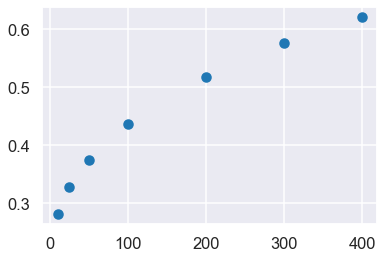

In [50]:
x,y = zip(*explained_variance)
plt.scatter(x,y);
#plt.savefig('Components_for_beers_.png')

In [51]:
SVD_300 = TruncatedSVD(n_components=300, random_state=42)
matrix_300= SVD_300.fit_transform(Transposed)
matrix_300.shape

(13274, 300)

In [52]:
#correlation/similarity matrix
corr_300 = np.corrcoef(matrix_300)
corr_300.shape

(13274, 13274)

In [53]:
#name of all beers
beer_rec_names_300= all_three_2_pivot.columns

#list of all beer names
beer_rec_list_300 = list(beer_rec_names_300)

In [54]:
def svd_300_recomm(string, n):
    '''
    function that returns top n-number of recommendations
    based on input of beer name and n
    inputs: string(name of beer) -> string
            n (n recommendations) -> int
    '''
    
    #we have to get the index of the beer name from list of all beers in training data
    get_index = beer_rec_list_300.index(string)
    
    similarities = corr_300[get_index]
    
    closest = []
    for idx, coeff in enumerate(similarities):
        closest.append((beer_rec_list_300[idx], coeff))
        
    closest.sort(key=lambda x: x[1], reverse=True)
    
    out=[]
    for i in range (1, n+1):
        out.append(closest[i][0])
    return out

In [55]:
#let's get the top 20 for a beer we looked at earlier
svd_300_recomm('Peanut Butter And Bals', 5)


['Humulus Wet',
 'Pharaoh',
 "Black Tuesday - S'more",
 'Dirty Beaver Juice Weekend',
 'Ad Lib']

In [56]:
(get_recommendation('Peanut Butter And Bals', 5))

['Mönchshof Schwarzbier',
 "Ol' Jack Frost Imperial Stout",
 'Double Shot',
 "Chunga's Old Bruin",
 'Drie Fonteinen Oude Geuze 1998 (50th Anniversary)']

In [57]:
#latent factors method
A = set(svd_300_recomm('Peanut Butter And Bals', 100))

#neighborhood method
B = set(get_recommendation('Peanut Butter And Bals',100))

print('common beers: {}'.format(A.intersection(B)))
print('number of common beers: {}'.format(len(A.intersection(B))))

common beers: {"Deeeez Smokin' Nuts", 'Doheny Double IPA', 'Mrs. Stoutfire - Rum Barrel-Aged'}
number of common beers: 3


In [58]:
def compare_recomm(name_list, n):
    
    results= []
    
    for idx, name in enumerate(name_list):
        svd = set(svd_300_recomm(name, n))
        knn = set(get_recommendation(name, n))
        common = len(svd.intersection(knn))
        tup = (idx, common)
        results.append(tup)
        
    x,y = zip(*results)
    plt.scatter(x,y, alpha=.4, marker='.')
    plt.xlabel('Beer No.')
    plt.ylabel('Common Recommendations')
    plt.show();

In [59]:
#select every 50 beers from highest avg rating to lowest avg rating
grouped = all_three_2.groupby('beer_name')
namelist = grouped.mean().sort_values(by='score', ascending=False)[::100].index.tolist()


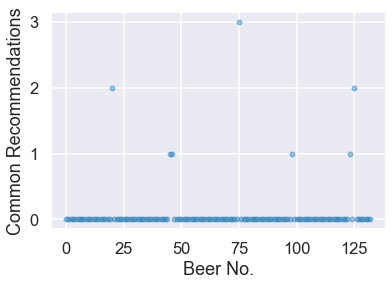

In [61]:
compare_recomm(namelist, 100)